In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now.. 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy and auto-causality from source
root_path = root_path = os.path.realpath('../..')
try: 
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))
    
try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

In [3]:

import numpy as np
import pandas as pd
from dowhy import CausalModel

In [4]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points) 

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

# build dataset (exclude confounder `ability` which we assume to be unobserved)
data = np.stack([education, income, voucher]).T
df = pd.DataFrame(data, columns = ['education', 'income', 'voucher'])

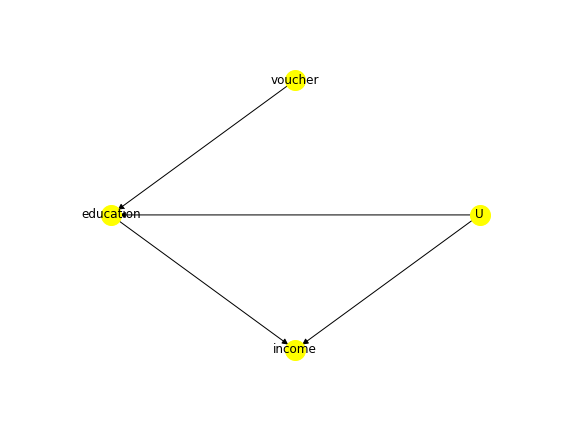

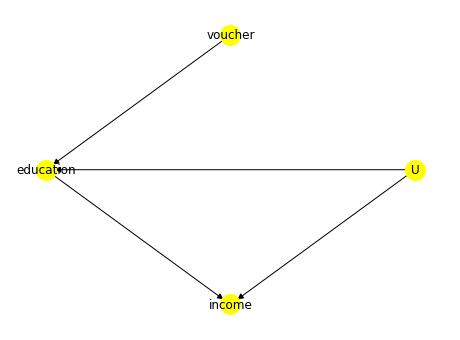

In [5]:
# Step 1: Model
model=CausalModel(
        data = df,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
# Step 3: Estimate
#Choose the second estimand: using IV
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.dml.NonParamDMLIV", test_significance=True)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
 ⎡   d            ⎤  -1⎡   d               ⎤
E⎢────────(income)⎥⋅E  ⎢────────(education)⎥
 ⎣dvoucher        ⎦    ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment